<a href="https://colab.research.google.com/github/sebastianJamesMI/Fellowship_AI_IMDB/blob/main/Sentiment_Analysis_IMDB_BERT_Tokenizer_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This project uses the IMDB dataset compiled by Andrew Maas (see http://a
i.stanford.edu/~amaas/data/sentiment/).

- The objective is to classify movie reviews as positive or negative. The original reviews were rated on a scale from 1 to 10. For Binary Classification, anything with <= 4 was classfed as negative and anything with >= 7 stars were classified as positive. 


############################################################################

I use different strategies to perform this classification task starting with a simple RNN model (LSTM) then using more complex models. 

############################################################################




This notebook uses a CNN model and the BERT tokenizer, but does not use the BERT pre-trained weights. It trains the weights from scratch. This notebook references the following sources:

1. NLP course on Udemy by Martin Jocqueviel: https://www.udemy.com/course/modern-nlp/

2. Data reading and downloading, Aaron Kub: 
https://towardsdatascience.com/sentiment-analysis-with-python-part-1-5ce197074184

3. Data Reading and Downloading: Georgios Drakos: https://gdcoder.com/sentiment-clas/

4. Word Tokenization: Coursera Deep learning NLP courses by Andrew Ng


Download the data from http://ai.stanford.edu/~amaas/data/sentiment/

In another notebook I downloaded the data and saved them as train.csv and test.csv files

In [ ]:
!pip install bert-for-tf2   ## not the official BERT source
!pip install sentencepiece

In [ ]:
## Import Dependencies
import numpy as np
import pandas as pd
from glob import glob
import random
import os
import re
import string
import math

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, LSTM, Dropout, Embedding, Bidirectional, Conv1D, GlobalMaxPooling1D

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
import tensorflow_hub as hub #site where pre-trained models are uploaded. will be needed when we need to download BERT weights
import bert

In [ ]:
## Read in train and test files, we can use these filesn for future notebooks
train_df = pd.read_csv('/content/drive/MyDrive/Projects/FellowshipAI/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/Projects/FellowshipAI/test.csv')

In [ ]:
print(train_df.shape)
print(test_df.shape)

(25000, 2)
(25000, 2)


In [ ]:
## An example of training data
print('The review text is: {}'.format(train_df['text'][0]))
print('\n')
print(f"The label is: {train_df['label'][0]}")

The review text is: BRIEF ENCOUNTER is a ghastly and pointless remake of the 1945 David Lean classic, which was based on Noel Coward's play "Still Life". A doctor removes a particle of grit from a woman's eye at a railway station, he is in a miserable relationship, she is happily married social worker of Italian ancestry. They meet by accident on another occasion, form an instant attraction and arrange to meet each other every Wednesday. The pair fall in love, but after spending a few afternoons together they realise that they have no realistic chance of happiness and agree to part. Coward's original one-act play concerned two ordinary people who fall in love. Sophia Loren and Richard Burton, two Super Stars and veterans of Hollywood Epics, are nobody's idea of 'ordinary people'. Loren in particular is miscast - Sophia Loren in full make-up, looking like a million dollars, working as a part-time voluntary social worker at a Citizen Advice Bureau just doesn't ring true. Burton, looking 

In [ ]:
##Preprocessing. Google tokenizer does this standard text preprocessing. Else we could use the following function
def clean_text(text):
    text = re.sub(r"@[A-Za-z0-9]+", ' ', text) ## this is useful for tweets
    text = re.sub(r"https?://[A-Za-z0-9./]+", ' ', text) ## replace urls
    text = re.sub(r"[^a-zA-Z.!?']", ' ', text) 
    text = re.sub(r" +", ' ',text) ## replacing too many white space with single white space
    return text

#train['text'].apply(clean_text)

In [ ]:
## Text data needs to be converted to numerical data using tokenizing
FullTokenizer = bert.bert_tokenization.FullTokenizer
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1", trainable = False)  ## BERT layer, we are not training the weights
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()  ## access to the vocab file as numpy
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = FullTokenizer(vocab_file, do_lower_case= do_lower_case)

In [ ]:
word_list = tokenizer.tokenize("I am training to be a data scientist")
word_list

['i', 'am', 'training', 'to', 'be', 'a', 'data', 'scientist']

In [ ]:
tokens = tokenizer.convert_tokens_to_ids(word_list)
tokens

[1045, 2572, 2731, 2000, 2022, 1037, 2951, 7155]

In [ ]:
def encode_sentence(sentence):
    word_list = tokenizer.tokenize(sentence)
    tokens = tokenizer.convert_tokens_to_ids(word_list)
    return tokens

In [ ]:
data_inputs = train_df['text'].apply(encode_sentence)
data_labels = train_df['label']

In [ ]:
data_inputs.shape

(25000,)

In [ ]:
## Creating Dataset
## we only want each batch to have the same length.

We create padded batches. For that:
1. Sort by length
2. Apply Padded batches

In [ ]:
data_with_len = [[sent, data_labels[i], len(sent)]
                 for i, sent in enumerate(data_inputs)]

random.shuffle(data_with_len)
data_with_len.sort(key = lambda x: x[2])
sorted_all = [(sent[0], sent[1])
               for sent in data_with_len if sent[2] > 7]

In [ ]:
## we need to call generator, for getting sentences of differnt lengths.
all_dataset = tf.data.Dataset.from_generator(lambda: sorted_all, output_types=(tf.int32, tf.int32))

In [ ]:
next(iter(all_dataset))

(<tf.Tensor: shape=(11,), dtype=int32, numpy=
 array([2023, 3185, 2003, 6659, 2021, 2009, 2038, 2070, 2204, 3896, 1012],
       dtype=int32)>, <tf.Tensor: shape=(), dtype=int32, numpy=0>)

In [ ]:
BATCH_SIZE = 32
all_batched = all_dataset.padded_batch(BATCH_SIZE, padded_shapes=((None, ), ()))

In [ ]:
next(iter(all_batched))

(<tf.Tensor: shape=(32, 36), dtype=int32, numpy=
 array([[ 2023,  3185,  2003, ...,     0,     0,     0],
        [ 1045,  2876,  1005, ...,     0,     0,     0],
        [ 7918, 14674,  7662, ...,     0,     0,     0],
        ...,
        [ 2302,  3160,  1010, ...,  1012,     0,     0],
        [ 2172,  2104,  9250, ...,  2802,  1012,     0],
        [ 6581,  2792,  3185, ...,  2184,  1013,  2184]], dtype=int32)>,
 <tf.Tensor: shape=(32,), dtype=int32, numpy=
 array([0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1,
        1, 1, 1, 0, 0, 1, 1, 0, 1, 1], dtype=int32)>)

In [ ]:
NB_BATCHES = math.ceil(len(sorted_all)/BATCH_SIZE)
NB_BATCHES_TEST = NB_BATCHES//10

In [ ]:
##shuffle because the datasets are ordered by length
all_batched.shuffle(NB_BATCHES)
val_dataset = all_batched.take(NB_BATCHES_TEST)
train_dataset = all_batched.skip(NB_BATCHES_TEST)

In [ ]:
# Data preprocessing is over
class DCNN(tf.keras.Model):

    def __init__(self, 
                 vocab_size,
                 emb_dim = 128,
                 nb_filters = 50,
                 FFN_units = 512,
                 nb_classes = 2,
                 dropout_rate = 0.3,
                 training = False,
                 name = 'dcnn'):
        super(DCNN, self).__init__(name = name)

        self.embedding = Embedding(vocab_size, 
                                   emb_dim)
        self.bigram = Conv1D(filters = nb_filters, 
                             kernel_size = 2, 
                             padding = 'valid',
                             activation = 'relu')
        self.trigram = Conv1D(filters = nb_filters, 
                             kernel_size = 3, 
                             padding = 'valid',
                             activation = 'relu')
        self.fourgram = Conv1D(filters = nb_filters, 
                             kernel_size = 4, 
                             padding = 'valid',
                             activation = 'relu')
        
        self.pool = GlobalMaxPooling1D()

        self.dense1 = Dense(units = FFN_units, activation = 'relu')
        self.dropout = Dropout(rate = dropout_rate)
        self.dense2 = Dense(1, activation = 'sigmoid')


    def call(self, inputs, training):
        x = self.embedding(inputs)
        
        x_1 = self.bigram(x)
        x_1 = self.pool(x_1)

        x_2 = self.trigram(x)
        x_2 = self.pool(x_2)

        x_3 = self.trigram(x)
        x_3 = self.pool(x_3)

        merged = tf.concat([x_1, x_2, x_3], axis = -1)  
        merged = self.dense1(merged)
        merged = self.dropout(merged, training)

        output = self.dense2(merged)
        return output



In [ ]:
# Training
VOCAB_SIZE = len(tokenizer.vocab)
EMB_DIM = 200
NB_FILTERS = 100
FFN_UNITS = 256
NB_CLASSES = 2
DROPOUT_RATE = 0.2
NB_EPOCHS = 5

In [ ]:
Dcnn = DCNN(vocab_size=VOCAB_SIZE, 
            emb_dim=EMB_DIM, 
            nb_filters=NB_FILTERS, 
            FFN_units=FFN_UNITS, 
            nb_classes=NB_CLASSES, 
            dropout_rate = DROPOUT_RATE)

In [ ]:
Dcnn.compile(loss = 'binary_crossentropy', 
             optimizer = 'adam',
             metrics = ['accuracy'])

In [ ]:
#set callbacks: Early Stopping and Reduce Learning Rate
def get_callbacks():
    """
    This function should create and return a tuple (early_stopping, learning_rate_reduction) callbacks.
    The callbacks should be instantiated according to the above requirements.
    """
    early_stopping = EarlyStopping(patience = 5, mode = 'min')
    learning_rate_reduction = ReduceLROnPlateau(factor=0.2, patience =3)
    return (early_stopping,learning_rate_reduction)

early_stopping, learning_rate_reduction = get_callbacks()
checkpoint = ModelCheckpoint(f"/content/drive/MyDrive/Projects/FellowshipAIweights.h5", monitor='val_loss', verbose=1, save_best_only=True,mode='min')

In [ ]:
history = Dcnn.fit(train_dataset, 
                   epochs = NB_EPOCHS, 
                   validation_data = val_dataset,
                   callbacks = [early_stopping,learning_rate_reduction, checkpoint])

Epoch 1/5
704/704 [==============================] - 111s 152ms/step - loss: 0.4490 - accuracy: 0.7650 - val_loss: 0.2606 - val_accuracy: 0.8982

Epoch 00001: val_loss improved from inf to 0.26059, saving model to /content/drive/MyDrive/Projects/FellowshipAIweights.h5
Epoch 2/5
704/704 [==============================] - 56s 79ms/step - loss: 0.1777 - accuracy: 0.9300 - val_loss: 0.2727 - val_accuracy: 0.9014

Epoch 00002: val_loss did not improve from 0.26059
Epoch 3/5
704/704 [==============================] - 56s 80ms/step - loss: 0.0721 - accuracy: 0.9751 - val_loss: 0.3272 - val_accuracy: 0.8986

Epoch 00003: val_loss did not improve from 0.26059
Epoch 4/5
704/704 [==============================] - 56s 79ms/step - loss: 0.0433 - accuracy: 0.9843 - val_loss: 0.3885 - val_accuracy: 0.8970

Epoch 00004: val_loss did not improve from 0.26059
Epoch 5/5
704/704 [==============================] - 57s 81ms/step - loss: 0.0075 - accuracy: 0.9980 - val_loss: 0.3985 - val_accuracy: 0.9022

Ep

In [ ]:
def plot_loss(history): ## plot the loss curves
    #Run this cell to plot the epoch vs accuracy graph

    try:
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
    except KeyError:
        plt.plot(history.history['acc'])
        plt.plot(history.history['val_acc'])
    plt.title('Accuracy vs. epochs')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show() 

    #Run this cell to plot the epoch vs loss graph
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Loss vs. epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'], loc='upper right')
    plt.show() 
    return None

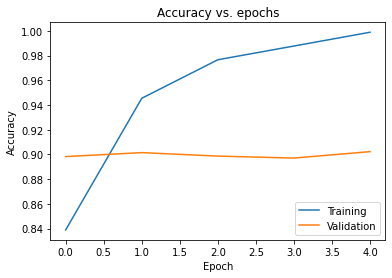

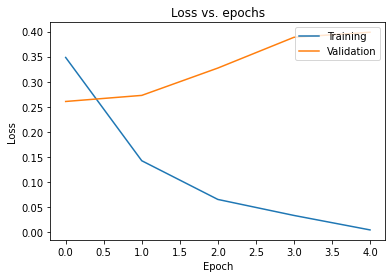

In [ ]:
plot_loss(history)

Evaluation

In [ ]:
##preparing the test dataset
test_data_inputs = test_df['text'].apply(encode_sentence)
test_data_labels = test_df['label']

test_data_with_len = [[sent, test_data_labels[i], len(sent)]
                 for i, sent in enumerate(test_data_inputs)]

random.shuffle(test_data_with_len)
test_data_with_len.sort(key = lambda x: x[2])
test_sorted_all = [(sent[0], sent[1])
               for sent in test_data_with_len if sent[2] > 7]

test_all_dataset = tf.data.Dataset.from_generator(lambda: test_sorted_all, output_types=(tf.int32, tf.int32))


In [ ]:
next(iter(test_all_dataset))

(<tf.Tensor: shape=(8,), dtype=int32, numpy=array([3191, 1996, 2338, 1010, 5293, 1996, 3185,  999], dtype=int32)>,
 <tf.Tensor: shape=(), dtype=int32, numpy=0>)

In [ ]:
test_all_batched = test_all_dataset.padded_batch(BATCH_SIZE, padded_shapes=((None, ), ()))

In [ ]:
TEST_NB_BATCHES = math.ceil(len(test_sorted_all)/BATCH_SIZE)

In [ ]:
##shuffle because the datasets are ordered by length
test_all_batched.shuffle(TEST_NB_BATCHES)
test_dataset = test_all_batched

In [ ]:
results = Dcnn.evaluate(test_dataset)

782/782 [==============================] - 15s 19ms/step - loss: 0.4851 - accuracy: 0.8856


In [ ]:
print(f'The Accuracy of model on the test dataset is: {results[1]:.2f}')

The Accuracy of model on the test dataset is: 0.89
